# Set up env

In [1]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt install git-lfs -y

Detected operating system as Ubuntu/jammy.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.4.10
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.5.1).
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.


In [2]:
!git clone https://huggingface.co/lmsys/vicuna-7b-v1.1 ./llm/vicuna-7b

Cloning into './llm/vicuna-7b'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), 10.28 KiB | 1.47 MiB/s, done.
Filtering content: 100% (3/3), 4.55 GiB | 70.65 MiB/s, done.


#### Large RAM is required to load the larger models. Running on GPU can optimize inference speed.

In [4]:
import sys
import os
import torch
import numpy as np
from lavis.models import load_model_and_preprocess

import decord
from decord import VideoReader
from decord import cpu, gpu
decord.bridge.set_bridge('torch')

import torchshow

#### Load an example video

In [5]:
def load_video(vr, start_time, end_time, fps, num_frames=20):
    start_index = int(round(start_time * fps))
    end_index = int(round(end_time * fps))
    select_frame_index = np.rint(np.linspace(start_index, end_index-1, num_frames)).astype(int).tolist()
    frames = vr.get_batch(select_frame_index).permute(3, 0, 1, 2).to(torch.float32)
    return frames

file_path = "example/video.mp4"
vr = VideoReader(file_path, ctx=cpu(0))
total_frames = len(vr)
fps = vr.get_avg_fps()
duration = total_frames / fps

print("video_duration: {:.1f}, fps: {:.1f}".format(duration, fps))

video_duration: 70.3, fps: 24.0


In [6]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print(device)

cuda


#### Visualize the full video

In [7]:
from IPython.display import HTML

# Embed video using HTML
HTML("""
<video width="640" height="480" controls>
  <source src="example/video.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>
""")

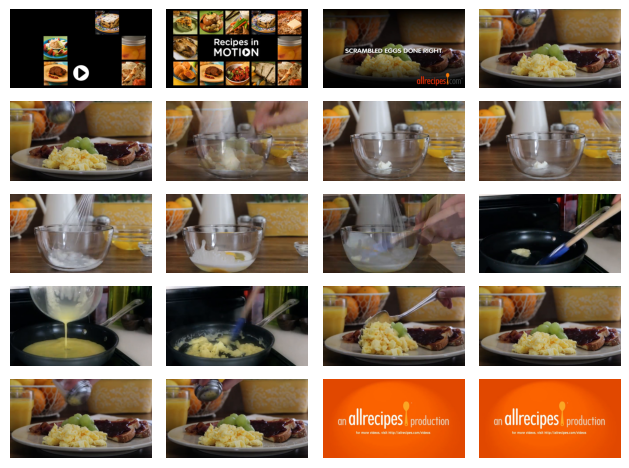

In [9]:
video = load_video(vr, start_time=0, end_time=duration, fps=fps, num_frames=20)

torchshow.show(video.squeeze().transpose(0,1))

#### Load pre-trained InstructBlip model weights

In [10]:
# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_vicuna_instruct_malmm", model_type="vicuna7b", is_eval=True, device=device
)
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_vicuna_instruct_malmm", model_type="vicuna13b", is_eval=True, device=device
# )

INFO:timm.models.hub:Downloading: "https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP2/eva_vit_g.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/eva_vit_g.pth

100%|██████████| 1.89G/1.89G [00:07<00:00, 287MB/s]
INFO:root:freeze vision encoder
INFO:root:BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): MBBertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (out

In [11]:
# you can change the memory_bank_length and num_frames in lavis/configs/models/blip2/blip2_instruct_vicuna7b.yaml
print(model.memory_bank_length)
print(model.num_frames)

10
20


#### Instructed zero-shot video-to-language generation

In [12]:
# load video by specifying the start_time and end_time
video = load_video(vr, start_time=0, end_time=duration, fps=fps, num_frames=20)
# prepare the video as model input using the associated processors
video = vis_processors["eval"](video).to(device).unsqueeze(0)
model.generate({"image": video, "prompt": "Question: what is the recipe of this video? Answer:"})

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


['scrambled eggs']

#### Online off-the-shelf setting with custom questions

In [13]:
video = load_video(vr, start_time=0, end_time=37, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)
model.generate({"image": video, "prompt": "Question: what will happen for the next 5 seconds? Answer:"})

['eggs will be scrambled']

#### Generate multiple answers

In [14]:
video = load_video(vr, start_time=0, end_time=duration, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)
model.generate({"image": video, "prompt": "Question: what does this video show? Answer:"}, num_captions=5)

['cooking', 'recipe', 'egg recipe', 'cooking eggs', 'egg recipe production']

# My testing

['eat', 'cook', 'bake', 'eating', 'cooking']

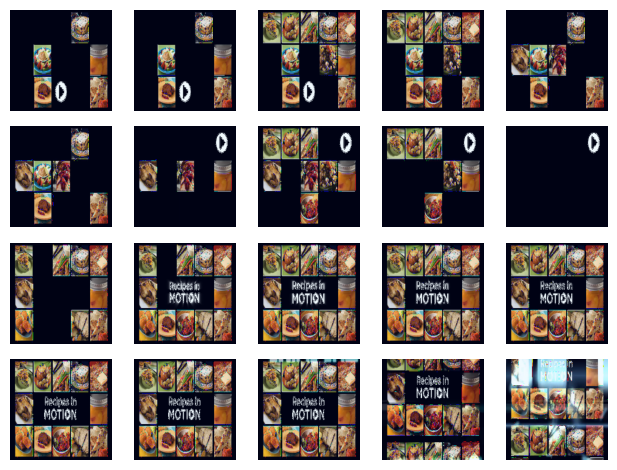

In [29]:
video = load_video(vr, start_time=0, end_time=5, fps=fps, num_frames=20)
video = vis_processors["eval"](video).to(device).unsqueeze(0)

torchshow.show(video.squeeze().transpose(0,1))

model.generate(
    {"image": video,
     "prompt": "Question: what happens next? Answer:"},
     num_captions=5
)